In [1]:
from collections import namedtuple
import random
from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from brokenaxes import brokenaxes
from meth5 import MetH5File

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from benchmark_pycometh.config import module_config
from benchmark_pycometh.segmentation.segmentation_comparer import SegmentsComparer, permute_segments, convert_to_cg_index, load_pycometh
from nanoepitools.reference_cpgs import ReferenceCpGs

In [2]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})
reference_cpgs = ReferenceCpGs("/home/r933r/data/resource/human/hg19/hg19_no_chr.fa")

sim_dir = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/"
ground_truth_file = f"{sim_dir}/wgbs/merged/changepoints.txt"

In [3]:
def load_methcp(path):
    return pd.read_csv(path, sep="\t", usecols=[0,1,2], names=["chrom", "start", "end"], dtype={"chrom":str})

def load_methylkit(path):
    return pd.read_csv(path, sep="\t", skiprows=1, usecols=[0,1,2], names=["chrom", "start", "end"], dtype={"chrom":str})

def load_gt(path):
    gt = pd.read_csv(path, sep="\t", names=["chrom", "start", "end", "segment_type", "theta"], dtype={"chrom":str})
    gt_only_diffmet = gt.loc[gt["theta"]!=0].copy()
    return gt, gt_only_diffmet

In [4]:
gt, gt_only_diffmet = load_gt(ground_truth_file)

In [5]:
predicted_segments = {
            "PycoMeth (15x)": load_pycometh(f"{sim_dir}/pycometh_15x/segmentation/segmentation_300_16.tsv"),
            "PycoMeth coarse (15x)": load_pycometh(f"{sim_dir}/pycometh_15x/segmentation/segmentation_600_16.tsv"),
            "MethylKit (15x)": load_methylkit(f"{sim_dir}/methylkit/methylkit_segmentation_15x.bed"),
            "MethCP (15x)": load_methcp(f"{sim_dir}/methcp/methcp_segments_15x.bed"),
            "PycoMeth": load_pycometh(f"{sim_dir}/pycometh/segmentation/segmentation_300_16.tsv"),
            "PycoMeth coarse": load_pycometh(f"{sim_dir}/pycometh/segmentation/segmentation_600_16.tsv"),
            "MethylKit": load_methylkit(f"{sim_dir}/methylkit/methylkit_segmentation_2.bed"),
            "MethCP": load_methcp(f"{sim_dir}/methcp/methcp_segments_2.bed")
            }

In [66]:
permuted_segments = {f"{k} (random)": permute_segments(v) for k,v in predicted_segments.items()}

In [6]:
#sc = SegmentsComparer(gt_segments=gt, predicted_segments={ki: permuted_segments[ki] if "random" in ki else predicted_segments[k] for k in predicted_segments for ki in [k, f"{k} (random)"]})
sc = SegmentsComparer(gt_segments=gt, predicted_segments=predicted_segments)

In [50]:
sc.gt_segments = gt
all_dists_from_gt = sc.compute_gt_dist_to_all_predicted()
all_dists_from_pred = sc.compute_predicted_dist_to_all_gt()

/home/r933r/miniconda3_4/envs/pycometh/lib/python3.8/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


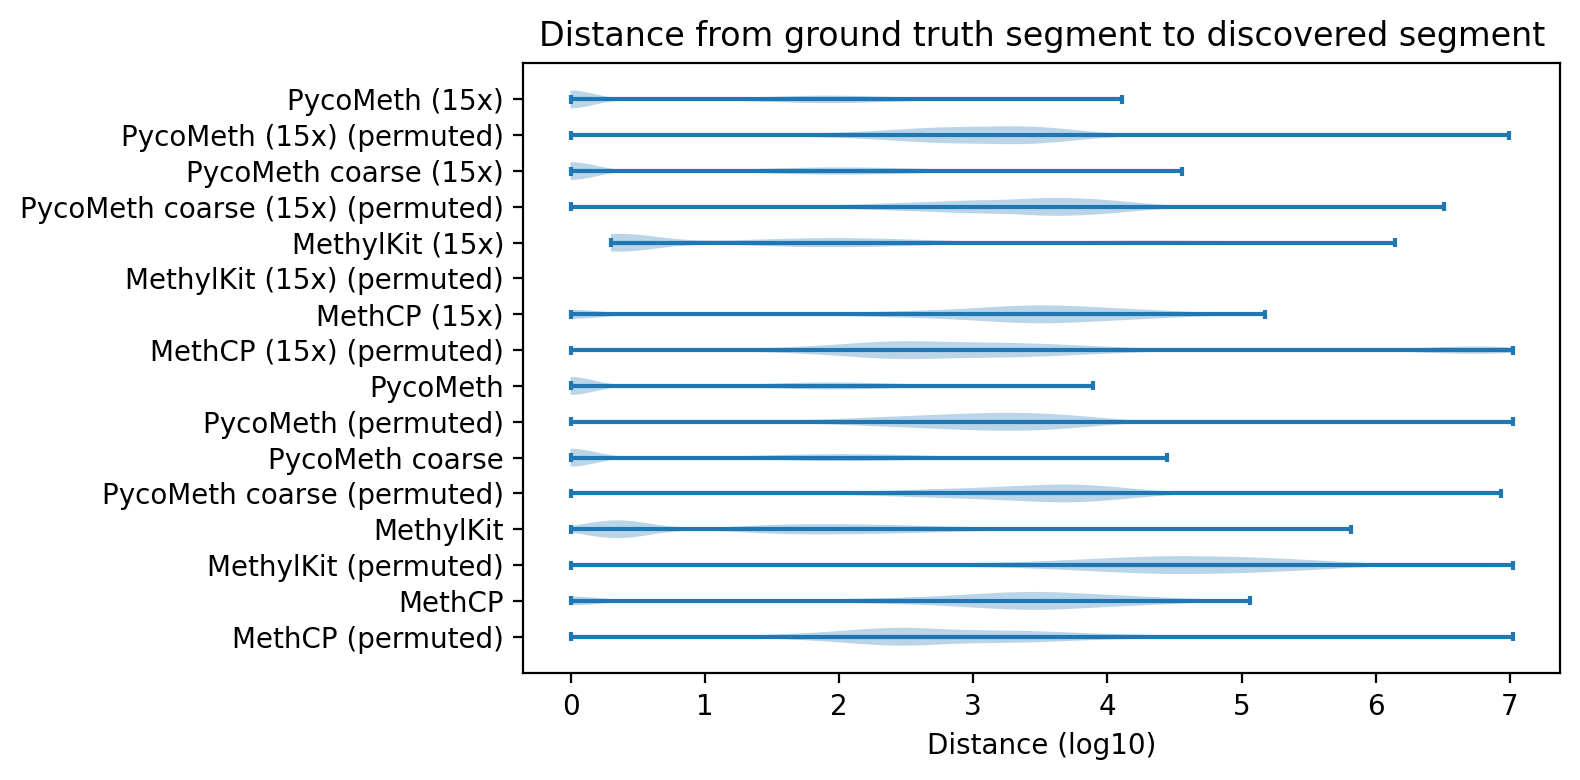

/home/r933r/miniconda3_4/envs/pycometh/lib/python3.8/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


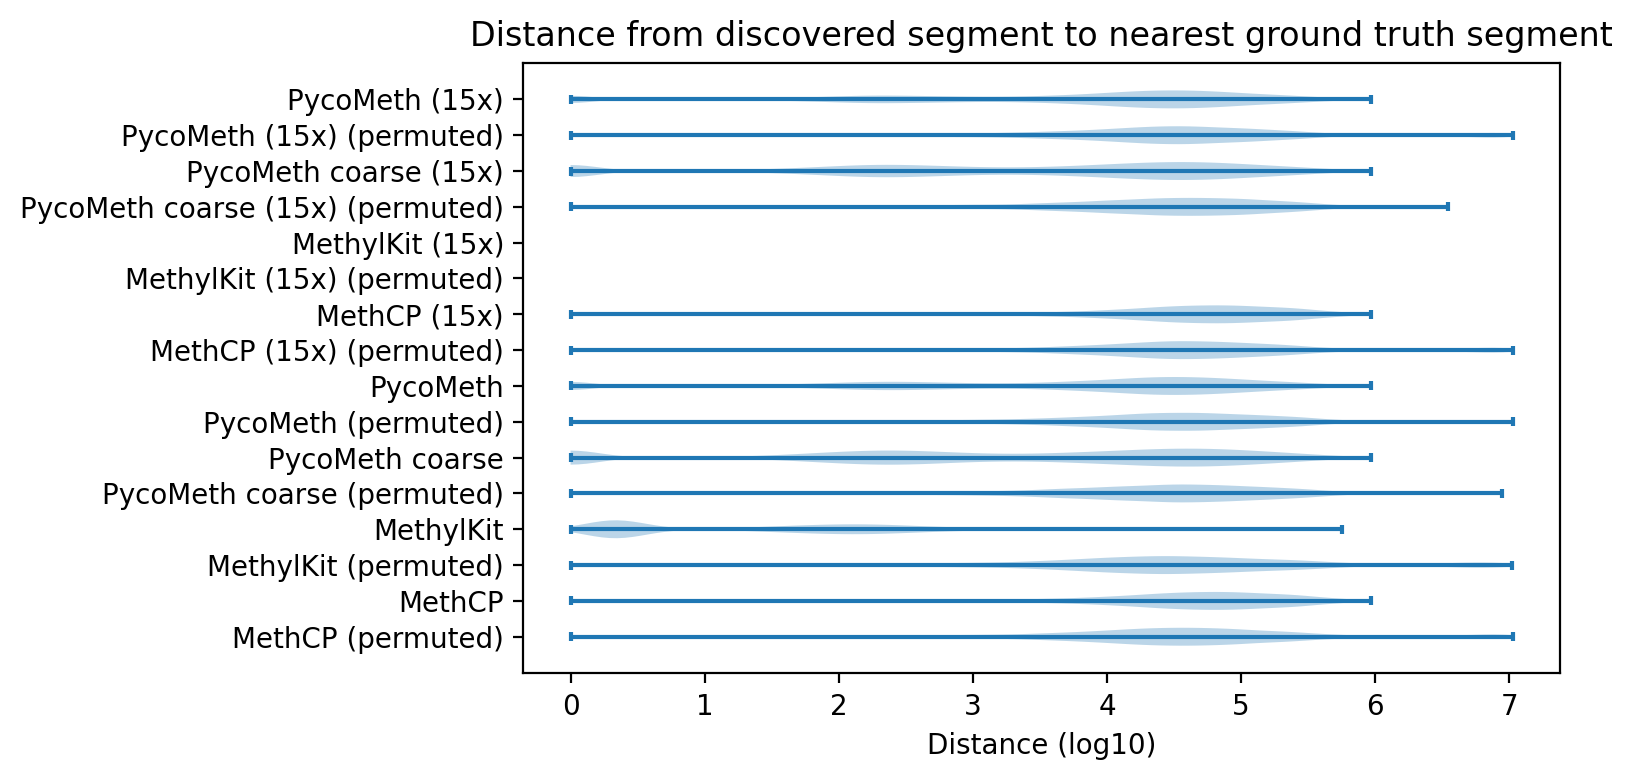

In [51]:
pa.figure(figsize=(8,4))
tools = list(all_dists_from_gt.keys())[::-1]
x = np.arange(len(tools))
plt.violinplot([np.log10(all_dists_from_gt[tool]+1) for tool in tools], positions=x, vert=False)
plt.yticks(x, tools)
plt.title("Distance from ground truth segment to discovered segment")
plt.xlabel("Distance (log10)")
pa.saveandshow("dist_disc_to_gt_combined")

pa.figure(figsize=(8,4))
plt.violinplot([np.log10(all_dists_from_pred[tool]+1) for tool in tools], positions=x, vert=False)
plt.yticks(x, tools)
plt.title("Distance from discovered segment to nearest ground truth segment")
plt.xlabel("Distance (log10)")
pa.saveandshow("dist_gt_to_disc_combined")

In [52]:
sc.gt_segments = gt_only_diffmet
all_dists_from_gt_gtonly = sc.compute_gt_dist_to_all_predicted()
all_dists_from_pred_gtonly = sc.compute_predicted_dist_to_all_gt()

/home/r933r/miniconda3_4/envs/pycometh/lib/python3.8/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


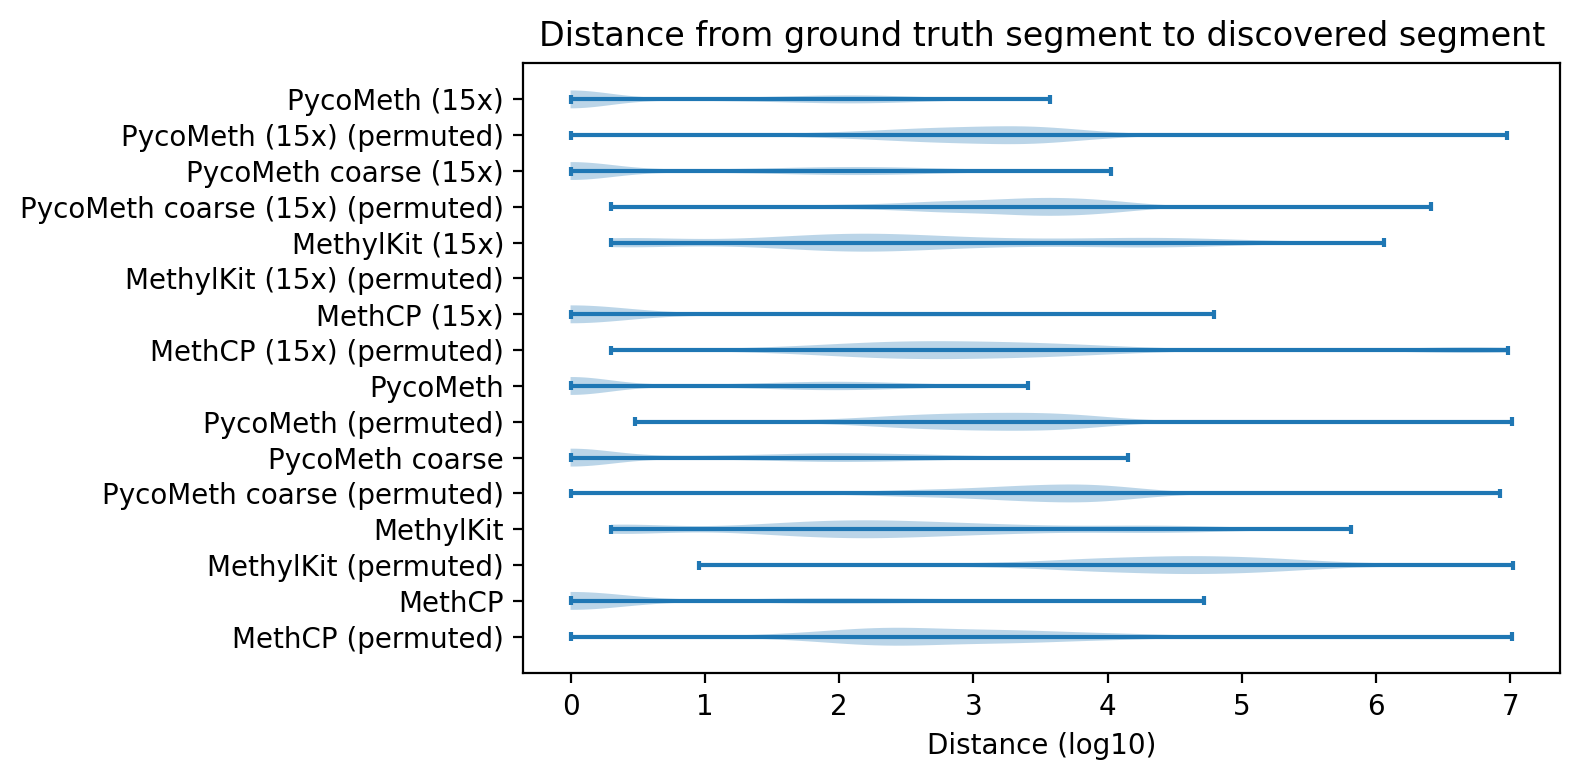

/home/r933r/miniconda3_4/envs/pycometh/lib/python3.8/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


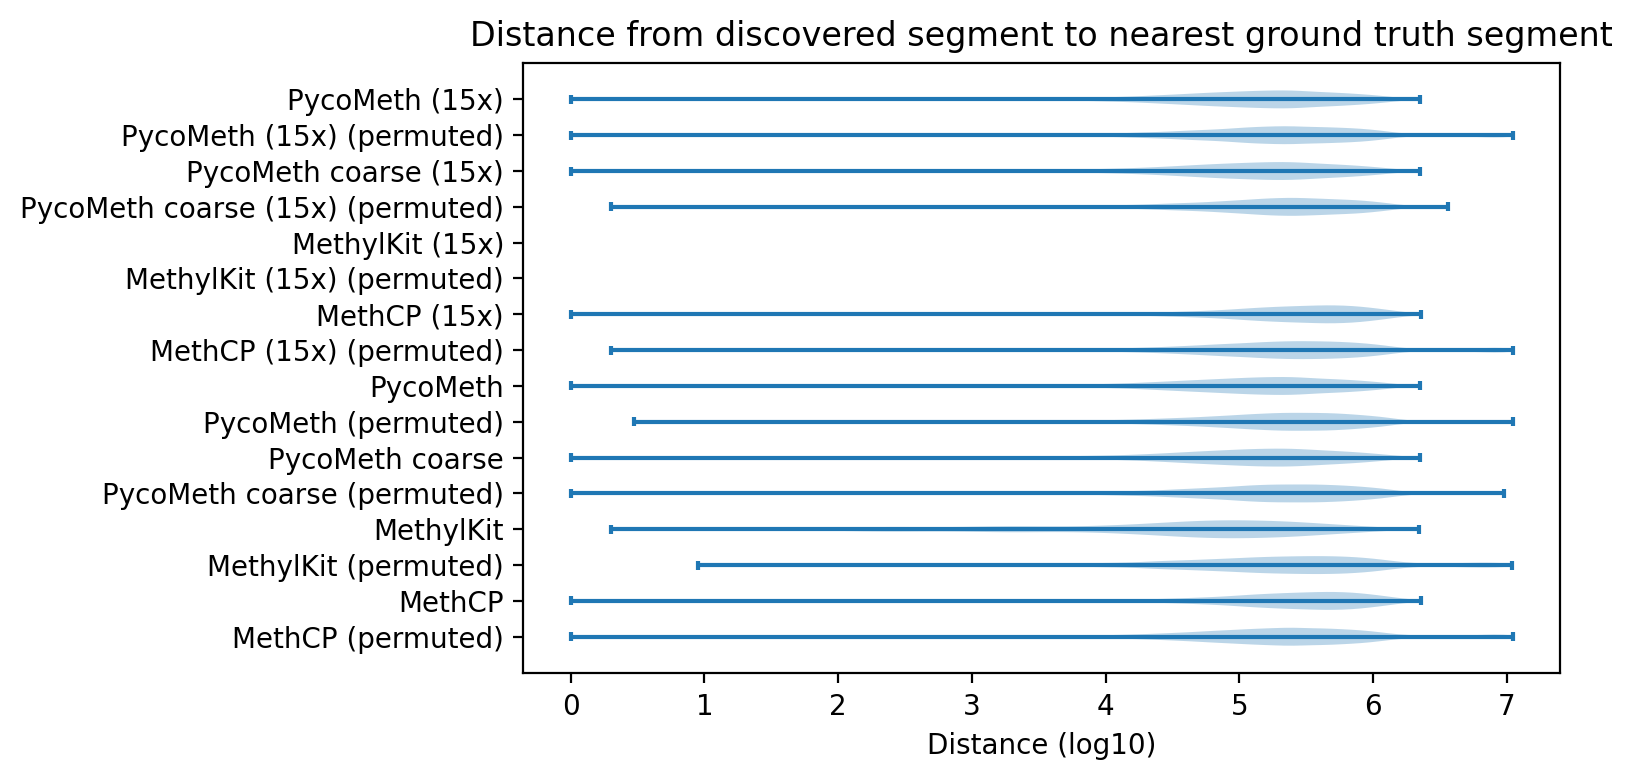

In [53]:
pa.figure(figsize=(8,4))
tools = list(all_dists_from_gt.keys())[::-1]
x = np.arange(len(tools))
plt.violinplot([np.log10(all_dists_from_gt_gtonly[tool]+1) for tool in tools], positions=x, vert=False)
plt.yticks(x, tools)
plt.title("Distance from ground truth segment to discovered segment")
plt.xlabel("Distance (log10)")
pa.saveandshow("dist_disc_to_gt_onlygt_combined")

pa.figure(figsize=(8,4))
plt.violinplot([np.log10(all_dists_from_pred_gtonly[tool]+1) for tool in tools], positions=x, vert=False)
plt.yticks(x, tools)
plt.title("Distance from discovered segment to nearest ground truth segment")
plt.xlabel("Distance (log10)")
pa.saveandshow("dist_gt_to_disc_onlygt_combined")


In [7]:
sc.gt_segments = gt

leftover_segments = {}
for tool in sc.predicted_segments:
    if "random" in tool:
        continue
    leftover_segments[tool] = sc.count_segments_identified(tool)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47007/47007 [08:34<00:00, 91.36it/s]


In [8]:
def count_leftover_segments(leftover, cps_not_used):
    counts = {}
    found = gt.drop(leftover.index)
    counts["Diffmet found"] = (found["theta"] != 0).sum()
    counts["Found"] = (found["theta"] == 0).sum()
    idx_leftover_diffmet = leftover["theta"] != 0
    counts["Diffmet one end"] = leftover.loc[idx_leftover_diffmet]["found_right"].sum() + leftover.loc[idx_leftover_diffmet]["found_left"].sum()
    counts["One end"] = leftover["found_right"].sum() + leftover["found_left"].sum() - counts["Diffmet one end"]

    counts["Diffmet not found"] = idx_leftover_diffmet.sum() - counts["Diffmet one end"]
    counts["Not found"] = (~idx_leftover_diffmet).sum() - counts["One end"]

    counts["Additional CPs"] = 0
    for a, b in zip(tqdm.tqdm(cps_not_used), cps_not_used[1:]):
        # this might be the same changepoint (just end and start merged)
        cgs = reference_cpgs.get_CGs("1", a+1, b-1)
        if len(cgs) > 0:
            counts["Additional CPs"] += 1

    return counts

tool_found_counts = {tool: count_leftover_segments(*leftover_segments[tool]) for tool in leftover_segments}

tool_found_counts["GT"]={"Diffmet found": len(gt_only_diffmet),
                         "Found": len(gt)-len(gt_only_diffmet)}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 84472/84473 [00:20<00:00, 4160.44it/s]


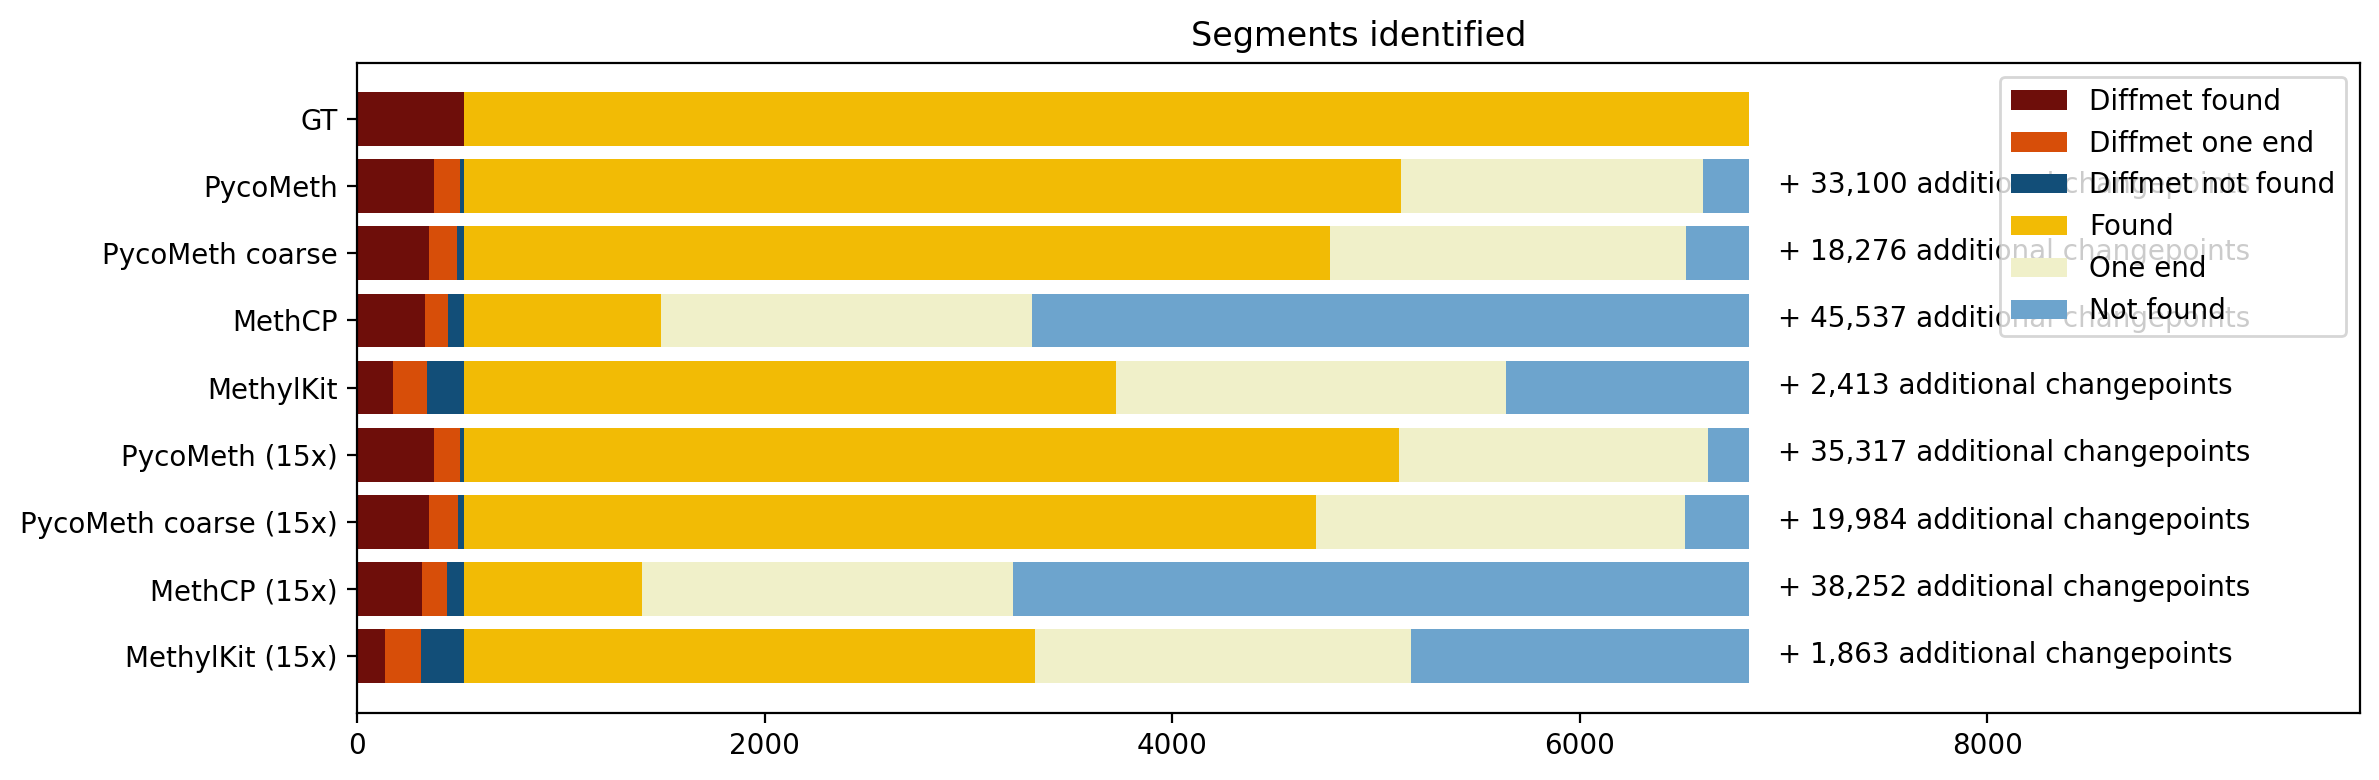

In [10]:
pa.figure(figsize=(12,4))
tools = ["GT", "PycoMeth", "PycoMeth coarse", "MethCP", "MethylKit",  "PycoMeth (15x)" , "PycoMeth coarse (15x)", "MethCP (15x)", "MethylKit (15x)"][::-1]
label_order = ["Diffmet found", "Diffmet one end", "Diffmet not found", "Found", "One end", "Not found"]#, "Additional CPs"]
colors = {"Diffmet found":"#6E0E0A", "Diffmet one end":"#D74E09", "Found":"#F2BB05", "One end":"#F0F0C9", "Diffmet not found":"#124E78", "Not found": "#6da4cd", "Additional CPs": "gray"}
bottom = [0 for _ in tools]
for label in label_order:
    h = [tool_found_counts[tool].get(label, 0) for tool in tools]
    plt.barh(tools, h, left=bottom, label=label, color=colors[label])
    bottom = [b+hi for b,hi in zip(bottom, h)]
xmax = plt.xlim()[1]
plt.xlim(0, xmax+3000)
for i, tool in enumerate(tools):
    if tool == "GT":
        continue
    a_cp = tool_found_counts[tool]["Additional CPs"]
    plt.text(xmax+100, i-0.1, f" + {a_cp:,} additional changepoints")

plt.title("Segments identified")
#plt.ylim(-0.5, len(tools)+1)
plt.legend()
pa.saveandshow("segments_correctly_found_combined")

In [26]:
for tool in tools:
    print("TOOL" , tool)
    print("Found DMRs:",tool_found_counts[tool].get("Diffmet found", 0) / tool_found_counts["GT"]["Diffmet found"])
    print("Partially DMRs:",tool_found_counts[tool].get("Diffmet one end", 0) / tool_found_counts["GT"]["Diffmet found"])
    print("Non DMRs:",tool_found_counts[tool].get("Found", 0) / tool_found_counts["GT"]["Found"])
    print("Partially NONDMR:",tool_found_counts[tool].get("One end", 0) / tool_found_counts["GT"]["Found"])
    print("Oversegmented: ", sum(tool_found_counts[tool].values()) / sum(tool_found_counts["GT"].values()) - 1)
    print()

TOOL MethylKit (15x)
Found DMRs: 0.26053639846743293
Partially DMRs: 0.33524904214559387
Non DMRs: 0.4445149017121116
Partially NONDMR: 0.2924857324032974
Oversegmented:  0.27276720351390926

TOOL MethCP (15x)
Found DMRs: 0.6053639846743295
Partially DMRs: 0.23754789272030652
Non DMRs: 0.13855421686746988
Partially NONDMR: 0.2891566265060241
Oversegmented:  5.600585651537335

TOOL PycoMeth coarse (15x)
Found DMRs: 0.6781609195402298
Partially DMRs: 0.2662835249042146
Non DMRs: 0.6629676601141408
Partially NONDMR: 0.2877298668357641
Oversegmented:  2.9259150805270866

TOOL PycoMeth (15x)
Found DMRs: 0.7260536398467433
Partially DMRs: 0.23754789272030652
Non DMRs: 0.7278059606848446
Partially NONDMR: 0.2403297400126823
Oversegmented:  5.17086383601757

TOOL MethylKit
Found DMRs: 0.33524904214559387
Partially DMRs: 0.3218390804597701
Non DMRs: 0.507292327203551
Partially NONDMR: 0.3037412809131262
Oversegmented:  0.3532942898975109

TOOL MethCP
Found DMRs: 0.6340996168582376
Partially DMR

In [45]:
for tool in tools:
    if "15x" in tool or tool=="GT":
        continue
    s30 = leftover_segments[tool][0]
    s15 = leftover_segments[f"{tool} (15x)"][0]
    f30 = {ix for i in set(gt.index).difference(set(s30.index)) for ix in [f"{i}_left", f"{i}_right"]}
    f15 = {ix for i in set(gt.index).difference(set(s15.index)) for ix in [f"{i}_left", f"{i}_right"]}
    f30 = f30.union({f"{i}_left" for i in s30.loc[s30["found_left"]].index})
    f30 = f30.union({f"{i}_right" for i in s30.loc[s30["found_right"]].index})
    f15 = f15.union({f"{i}_left" for i in s15.loc[s15["found_left"]].index})
    f15 = f15.union({f"{i}_right" for i in s15.loc[s15["found_right"]].index})

    agreement = len(f30.intersection(f15)) / len(f30.union(f15))
    print(tool, len(f30), len(f15), agreement)

MethylKit 8834 7900 0.759251471825063
MethCP 4538 4328 0.8493950771798081
PycoMeth coarse 11098 11026 0.8182117028270874
PycoMeth 11566 11580 0.83785929807845


In [50]:
not_found_30 = leftover_segments["PycoMeth"][0].loc[leftover_segments["PycoMeth"][0].apply(lambda x: not x["found_left"] and not x["found_right"], axis=1)]

In [51]:
not_found_15 = leftover_segments["PycoMeth (15x)"][0].loc[leftover_segments["PycoMeth (15x)"][0].apply(lambda x: not x["found_left"] and not x["found_right"], axis=1)]

In [55]:
len(not_found_30.index.intersection(not_found_15.index)) / len(not_found_30.index.union(not_found_15.index))

0.23076923076923078

In [92]:
from nanoepitools.plotting.plot_methylation_profile import plot_met_profile_from_matrix, plot_met_profile
from meth5 import MetH5File
simulated_m5 = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/diffmet_merged_15x.m5"
simulated_m5 = MetH5File(simulated_m5, "r")

def plot_methylation_all_segments(chrom, start, end, highlights=[]):
    matrix = simulated_m5[chrom].get_values_in_range(start, end).to_sparse_methylation_matrix(read_groups_key="sample")
    fig, ax = pa.subplots(6,1, figsize=(20,12))
    for i, tool in enumerate(["GT", "PycoMeth", "PycoMeth coarse", "PycoMeth (15x)", "MethCP", "MethylKit"]):
        if tool == "GT":
            seg = gt
        else:
            seg = sc.predicted_segments[tool]
        plt.sca(ax[i])
        plt.title(tool)
        plot_met_profile_from_matrix(matrix, aggregate_samples=True, highlights=highlights, highlights_in_genomic_space=True)
        plt.vlines(seg.loc[(seg["start"] > start)&(seg["start"] < end)]["start"], plt.ylim()[0], plt.ylim()[1], color="r")
    plt.show()

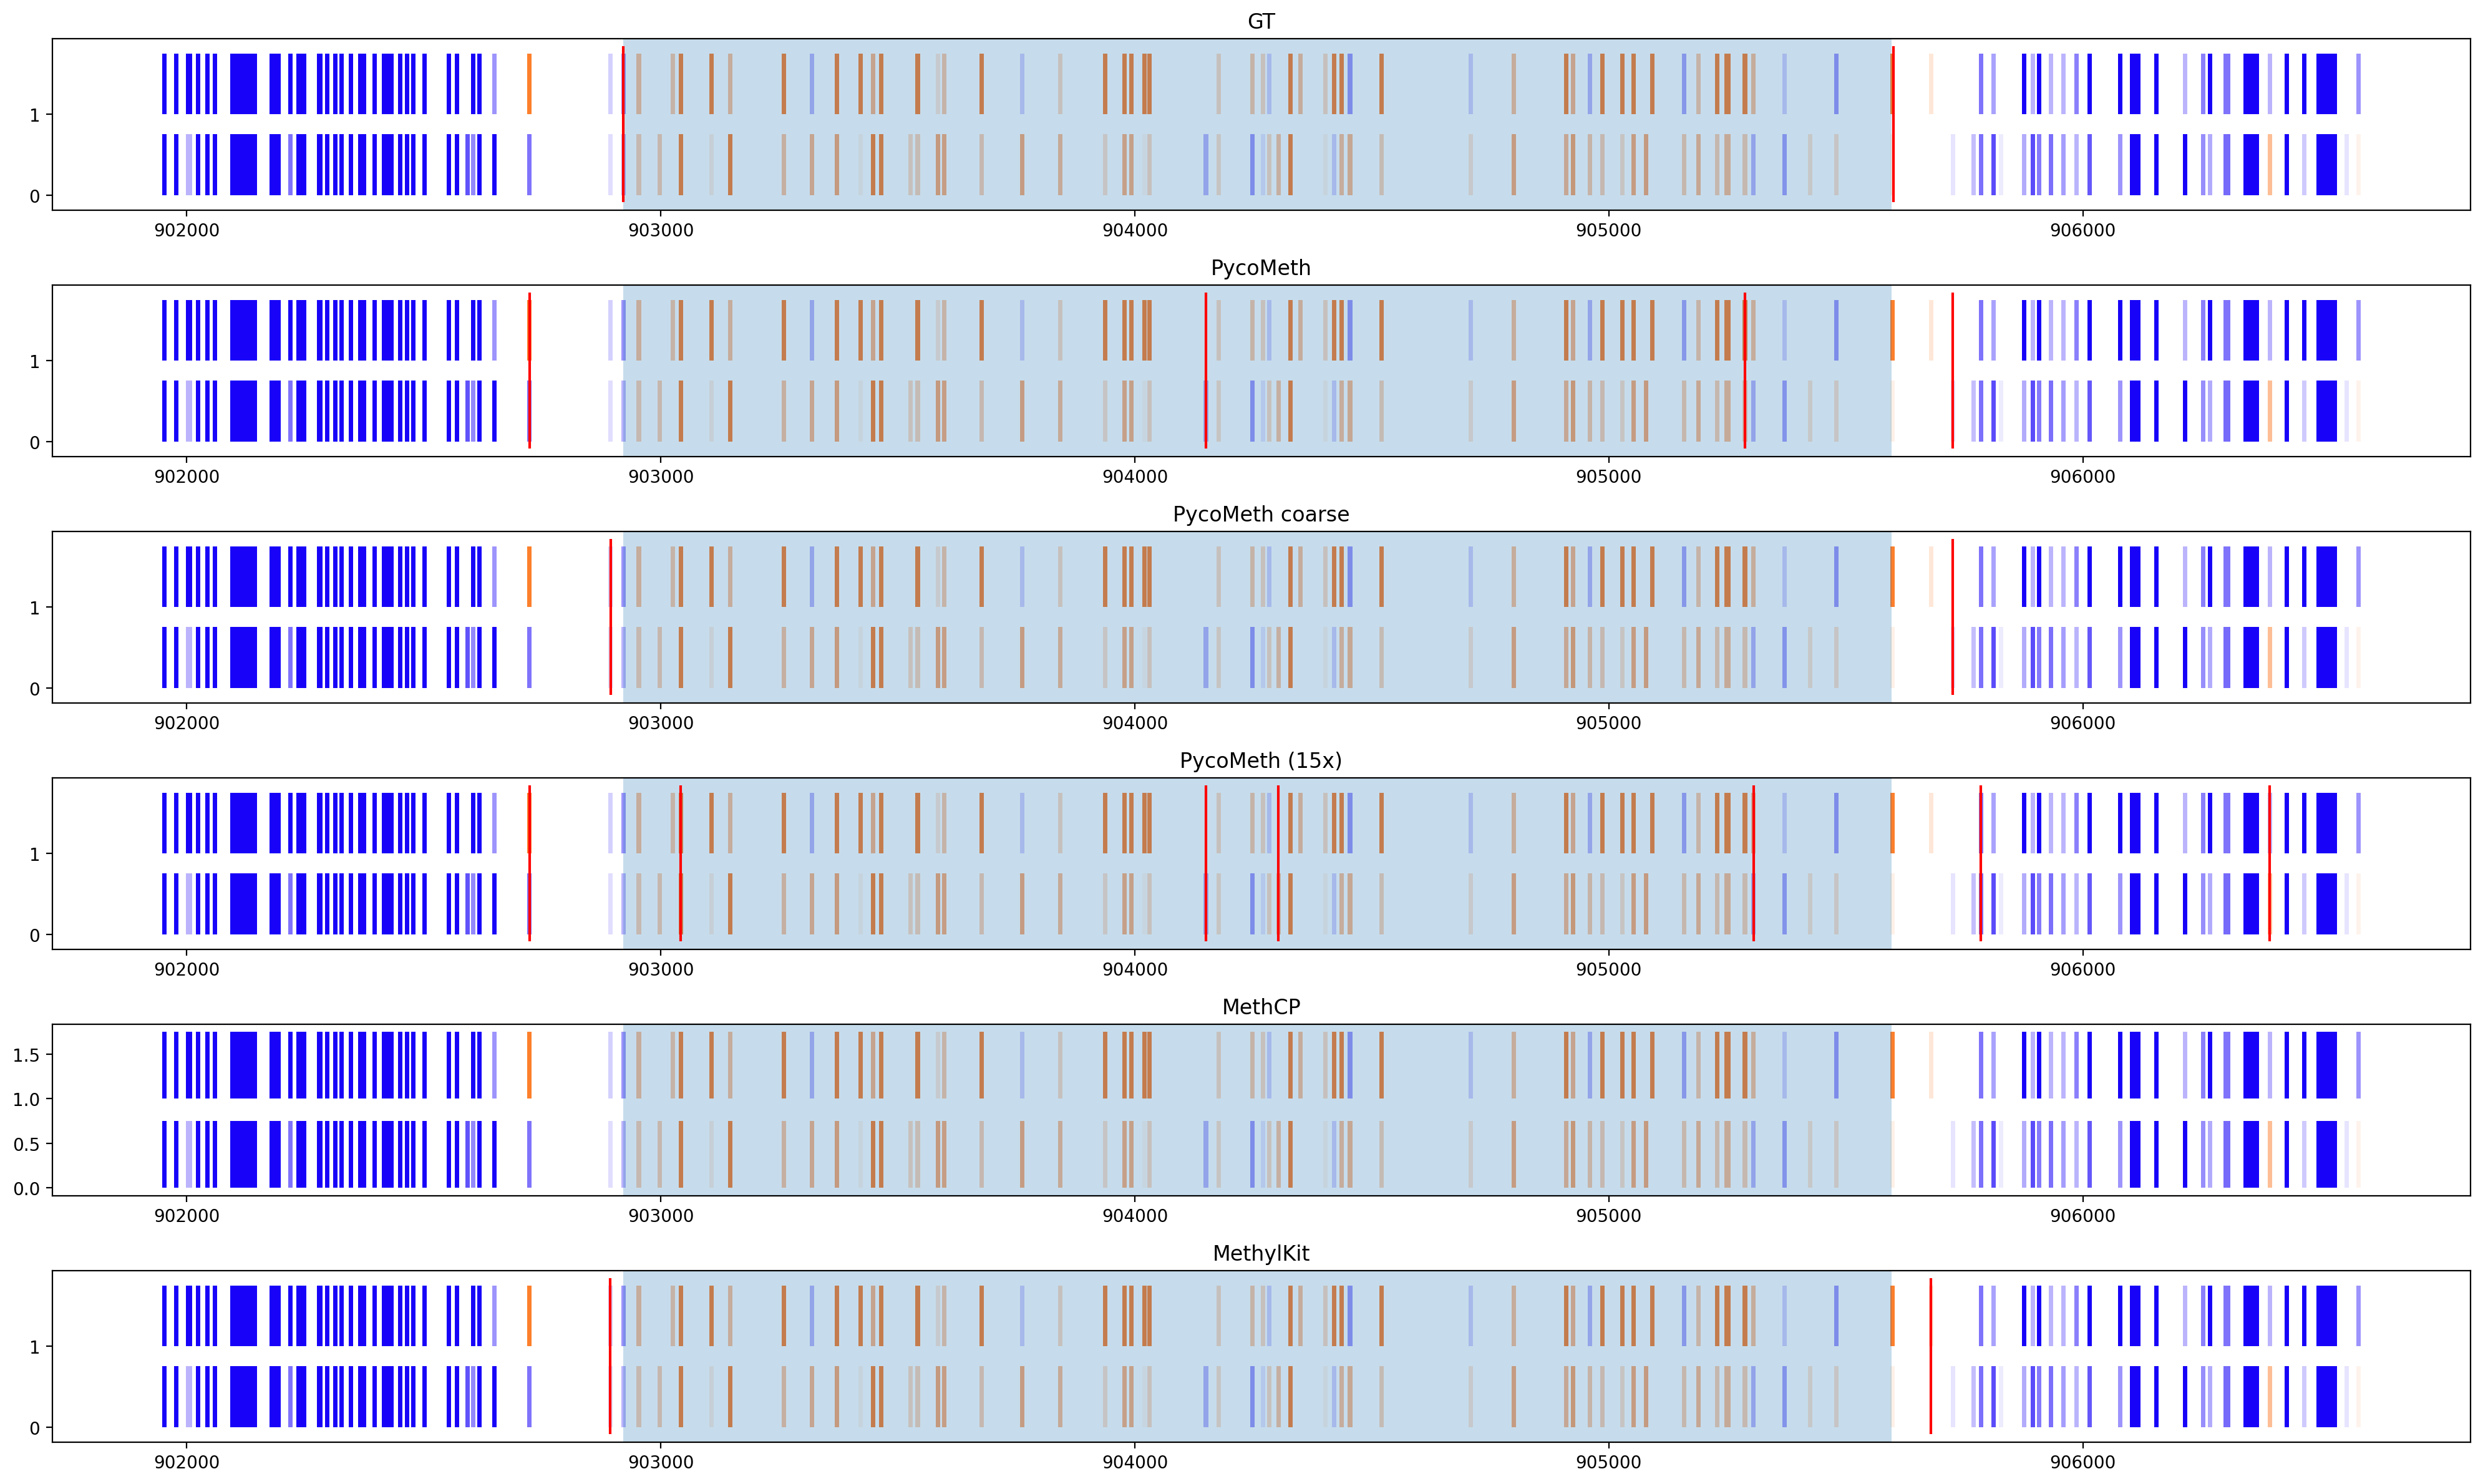

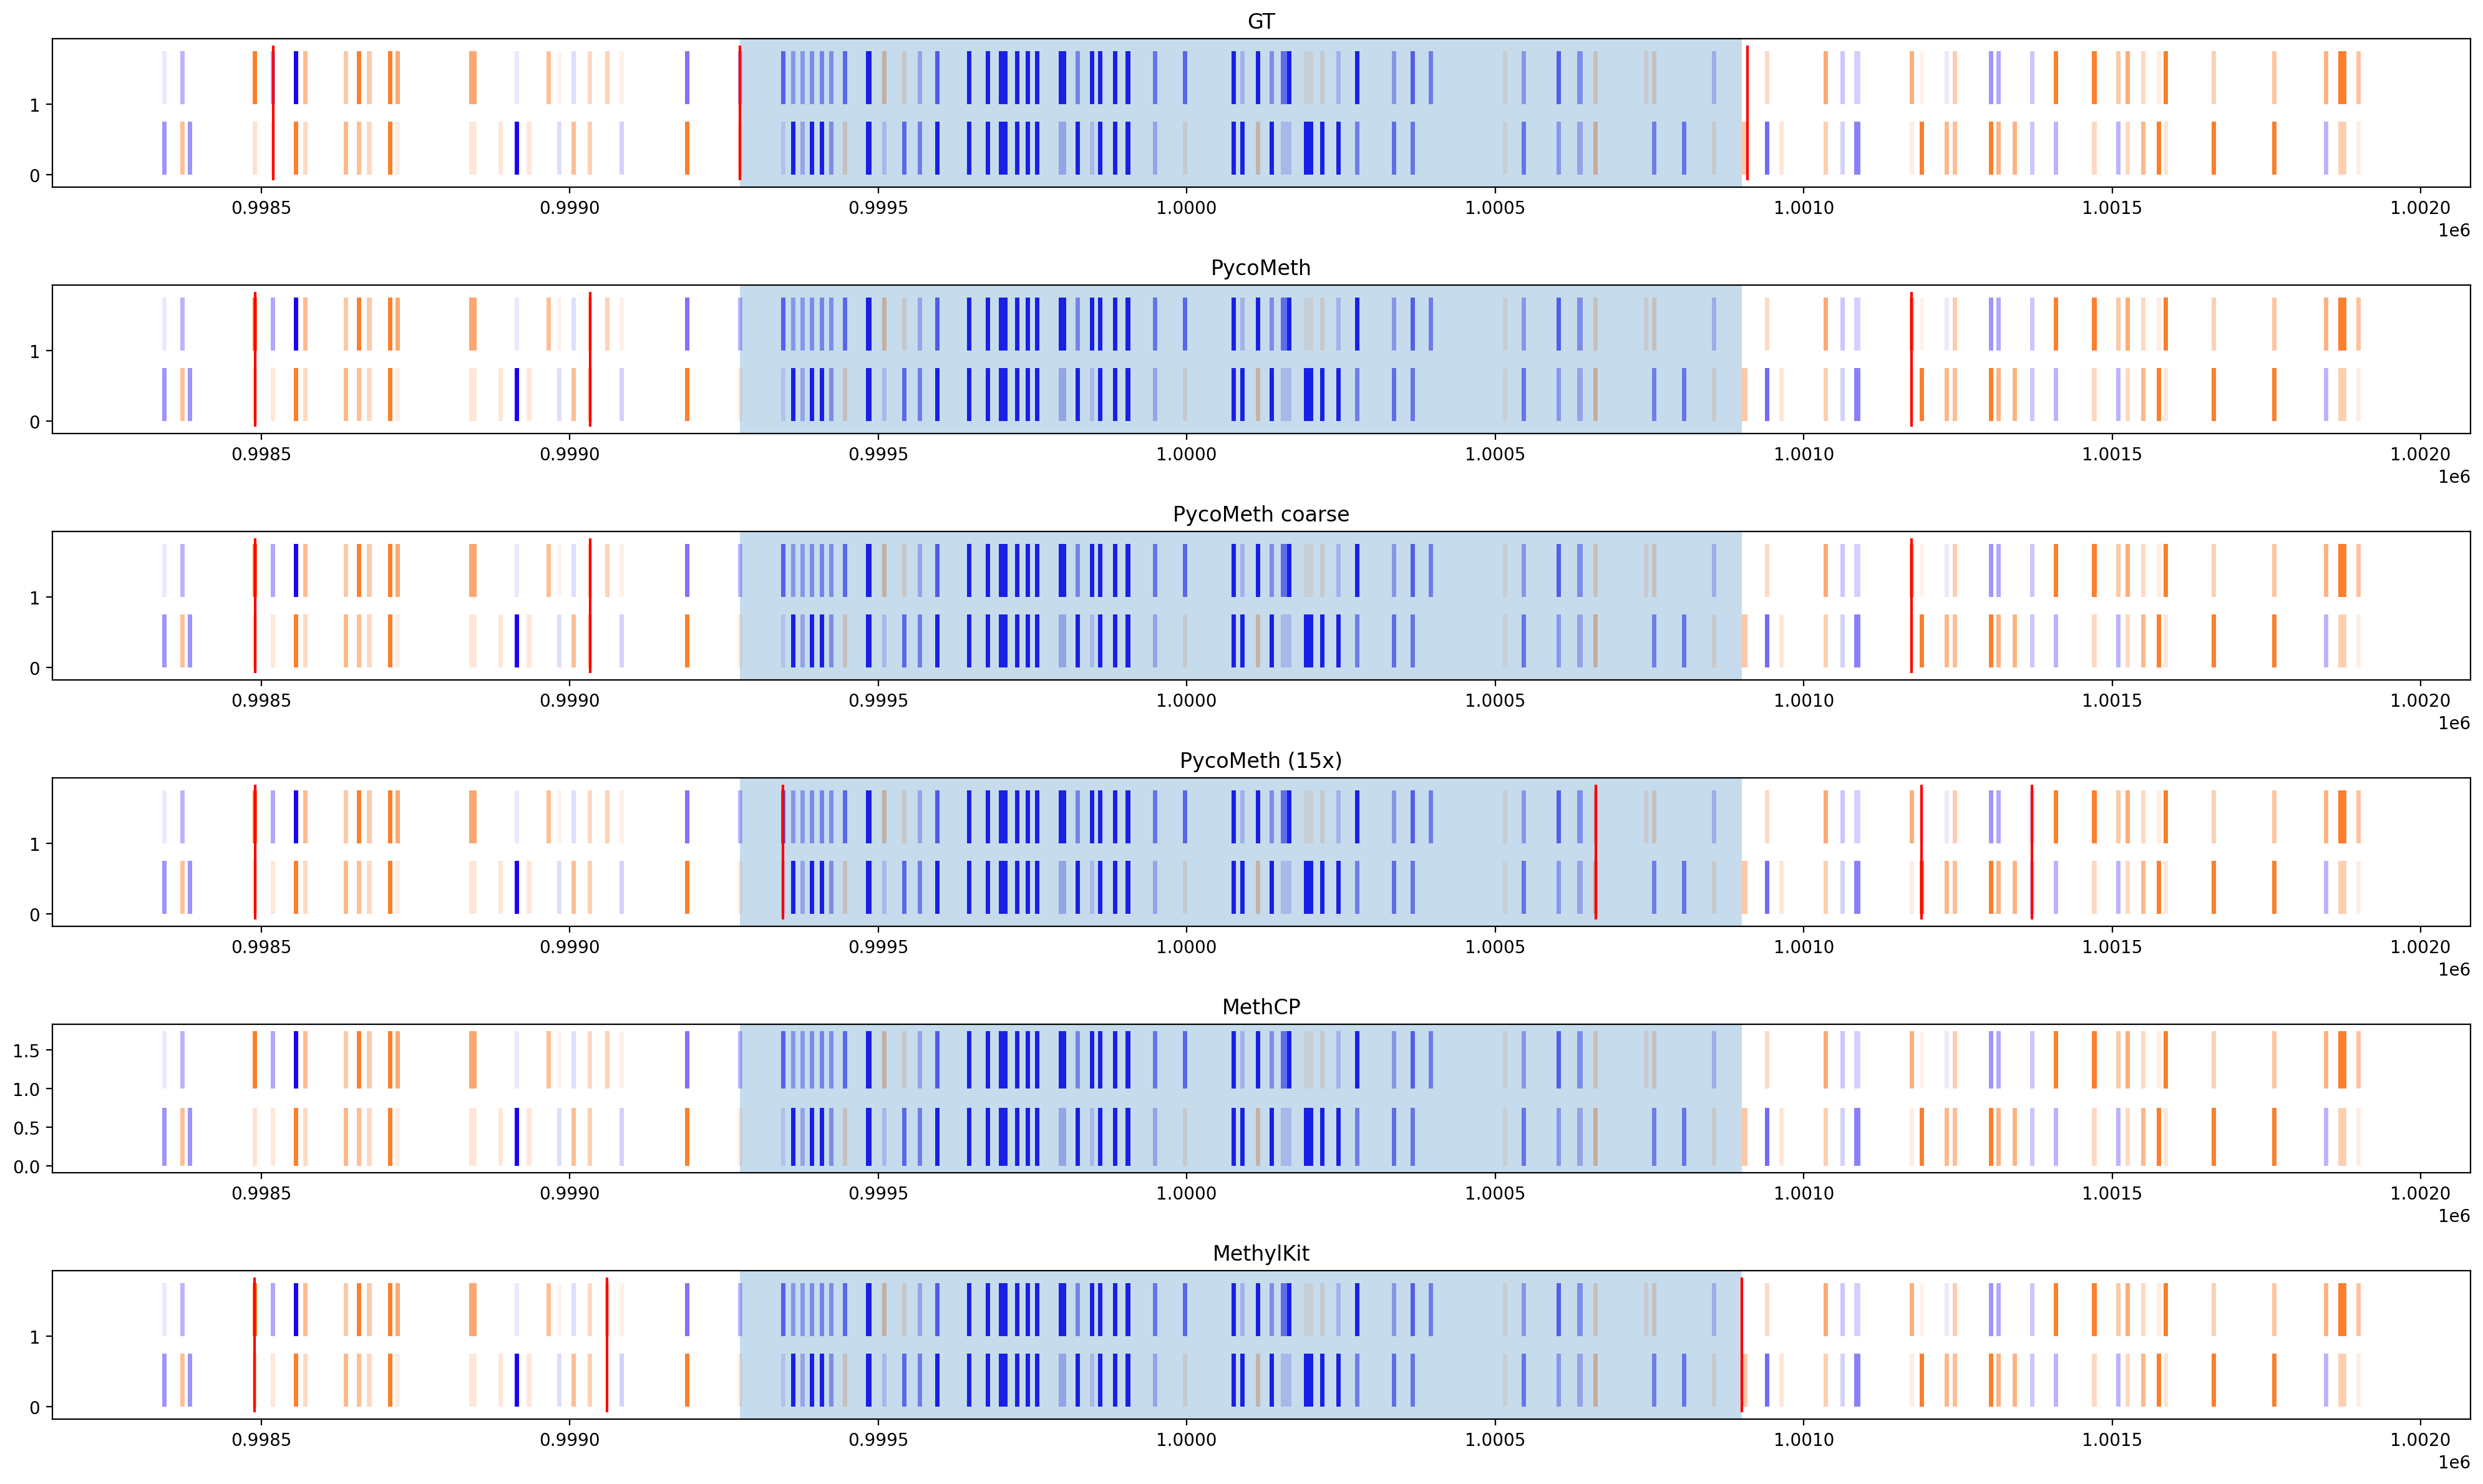

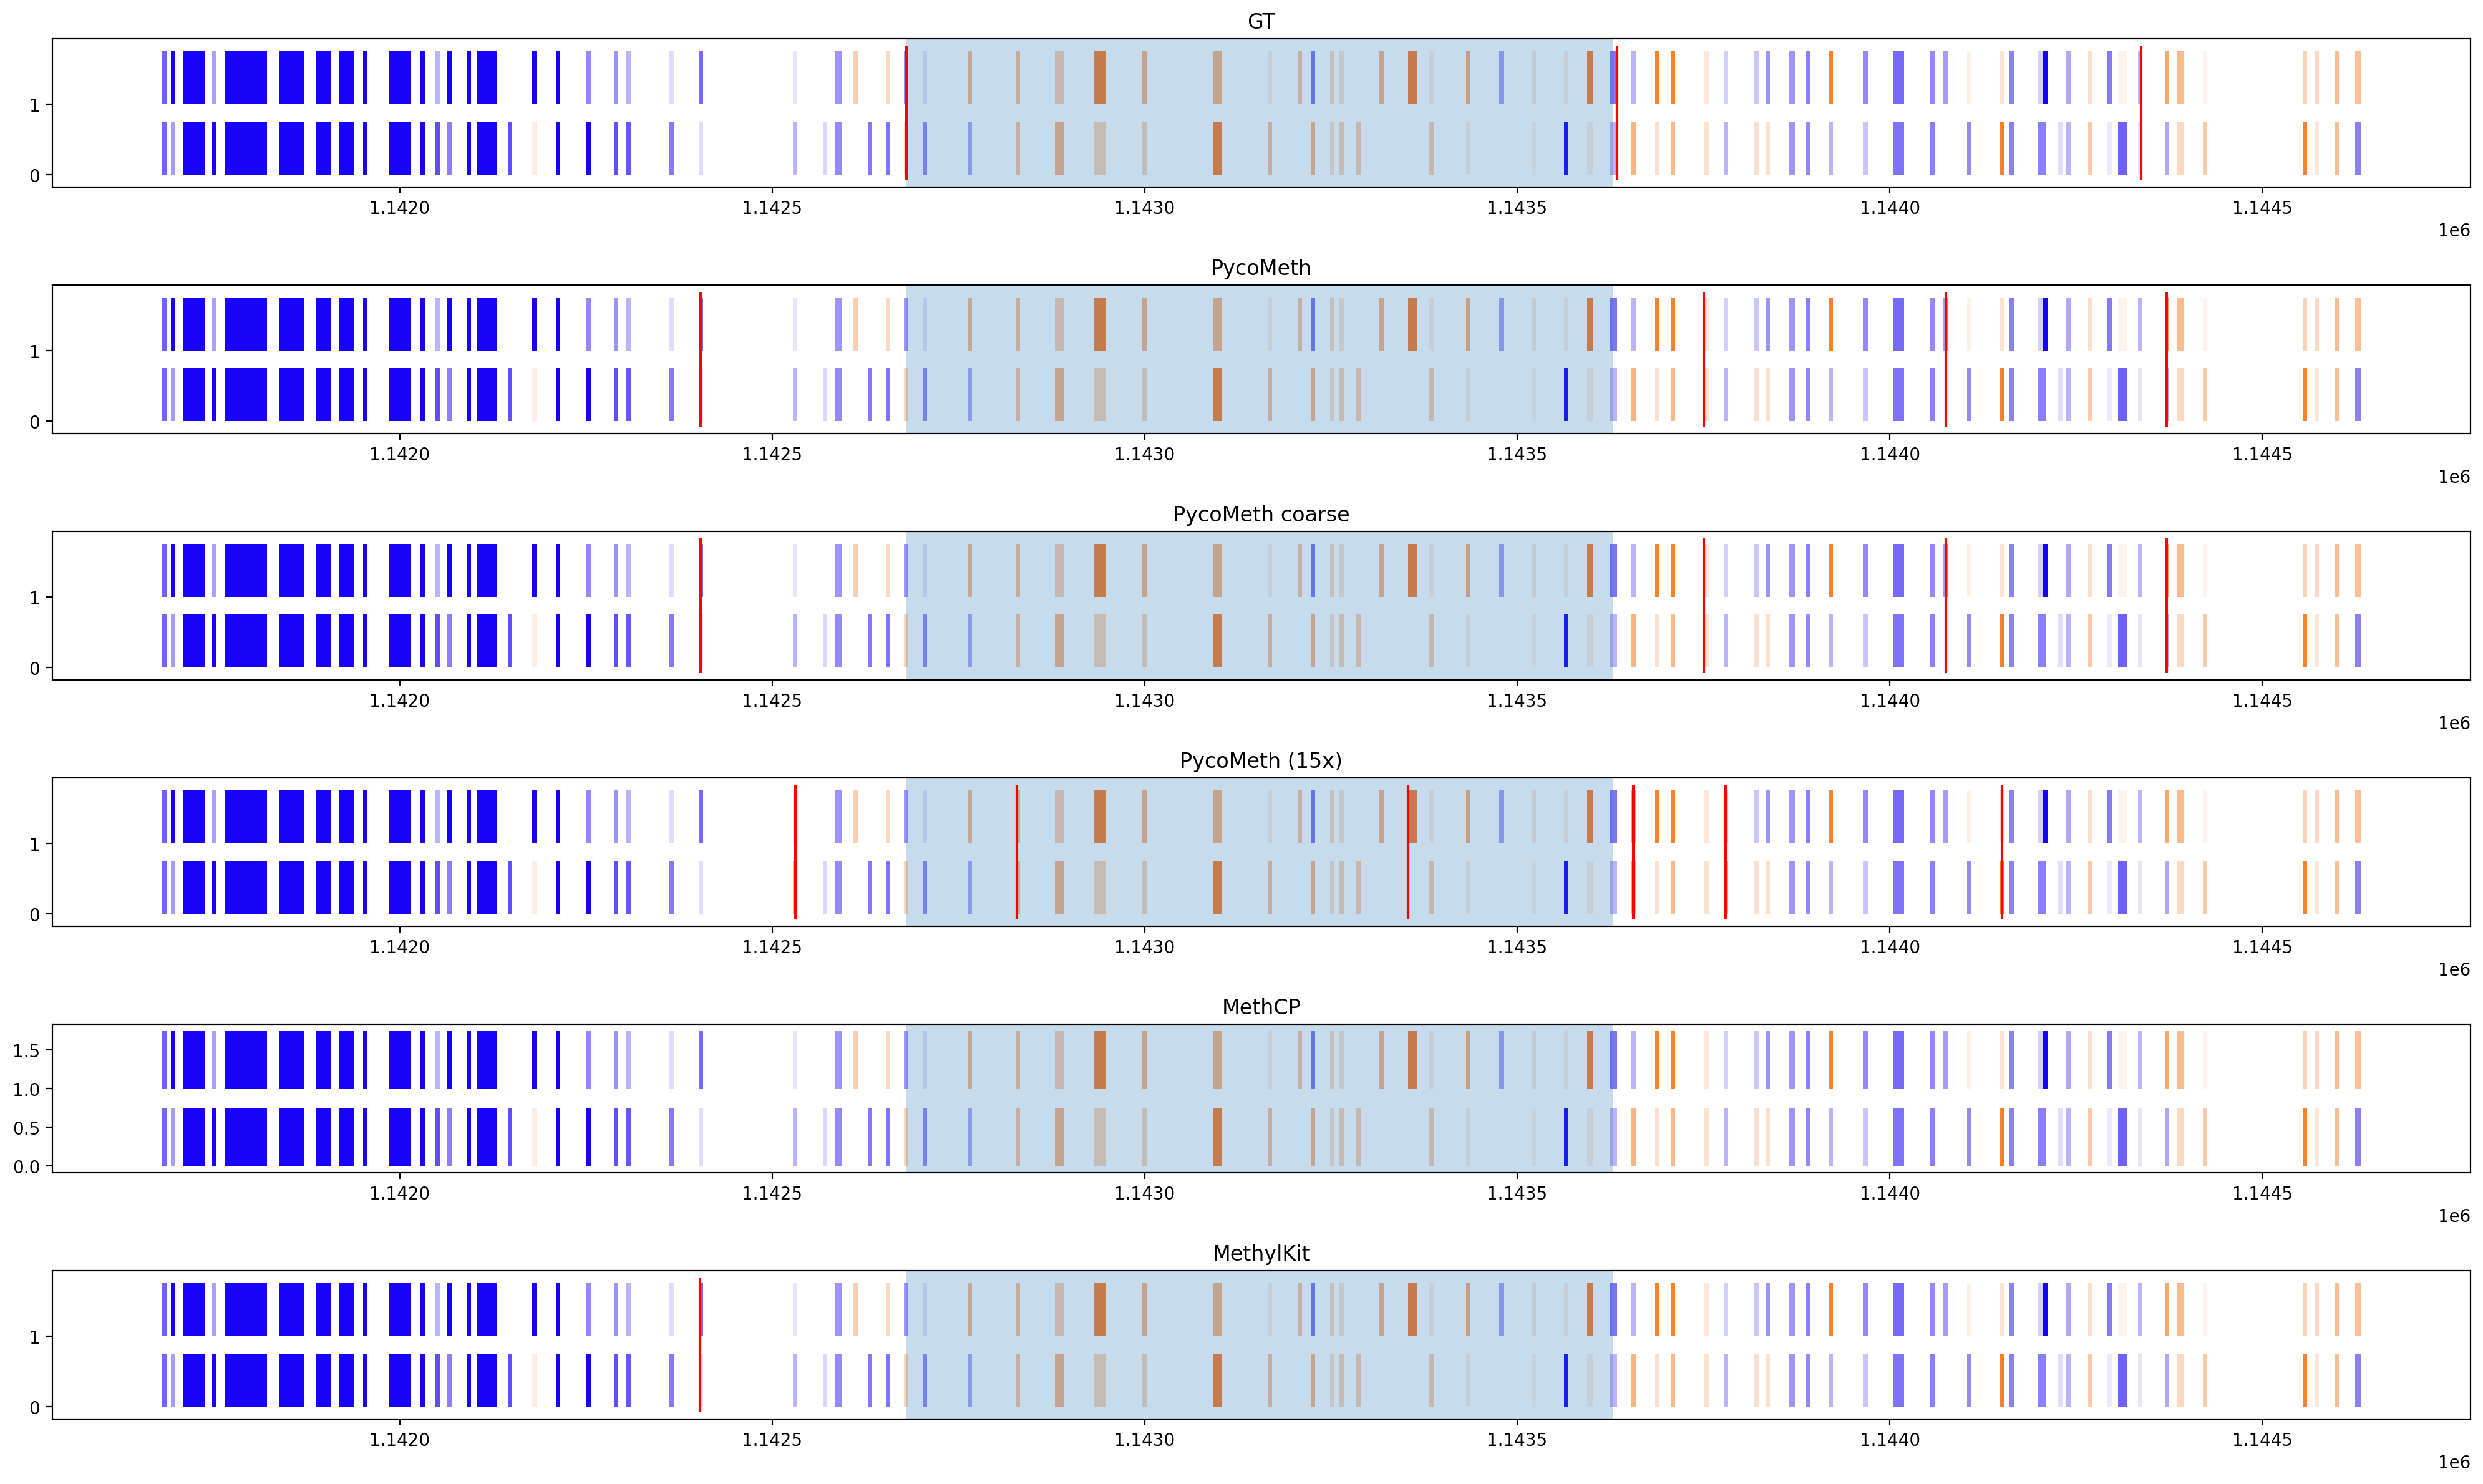

KeyboardInterrupt: 

In [93]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for _, row in not_found_30.iterrows():
        plot_methylation_all_segments("1", row.start-1000, row.end+1000, highlights=[(row.start, row.end)])

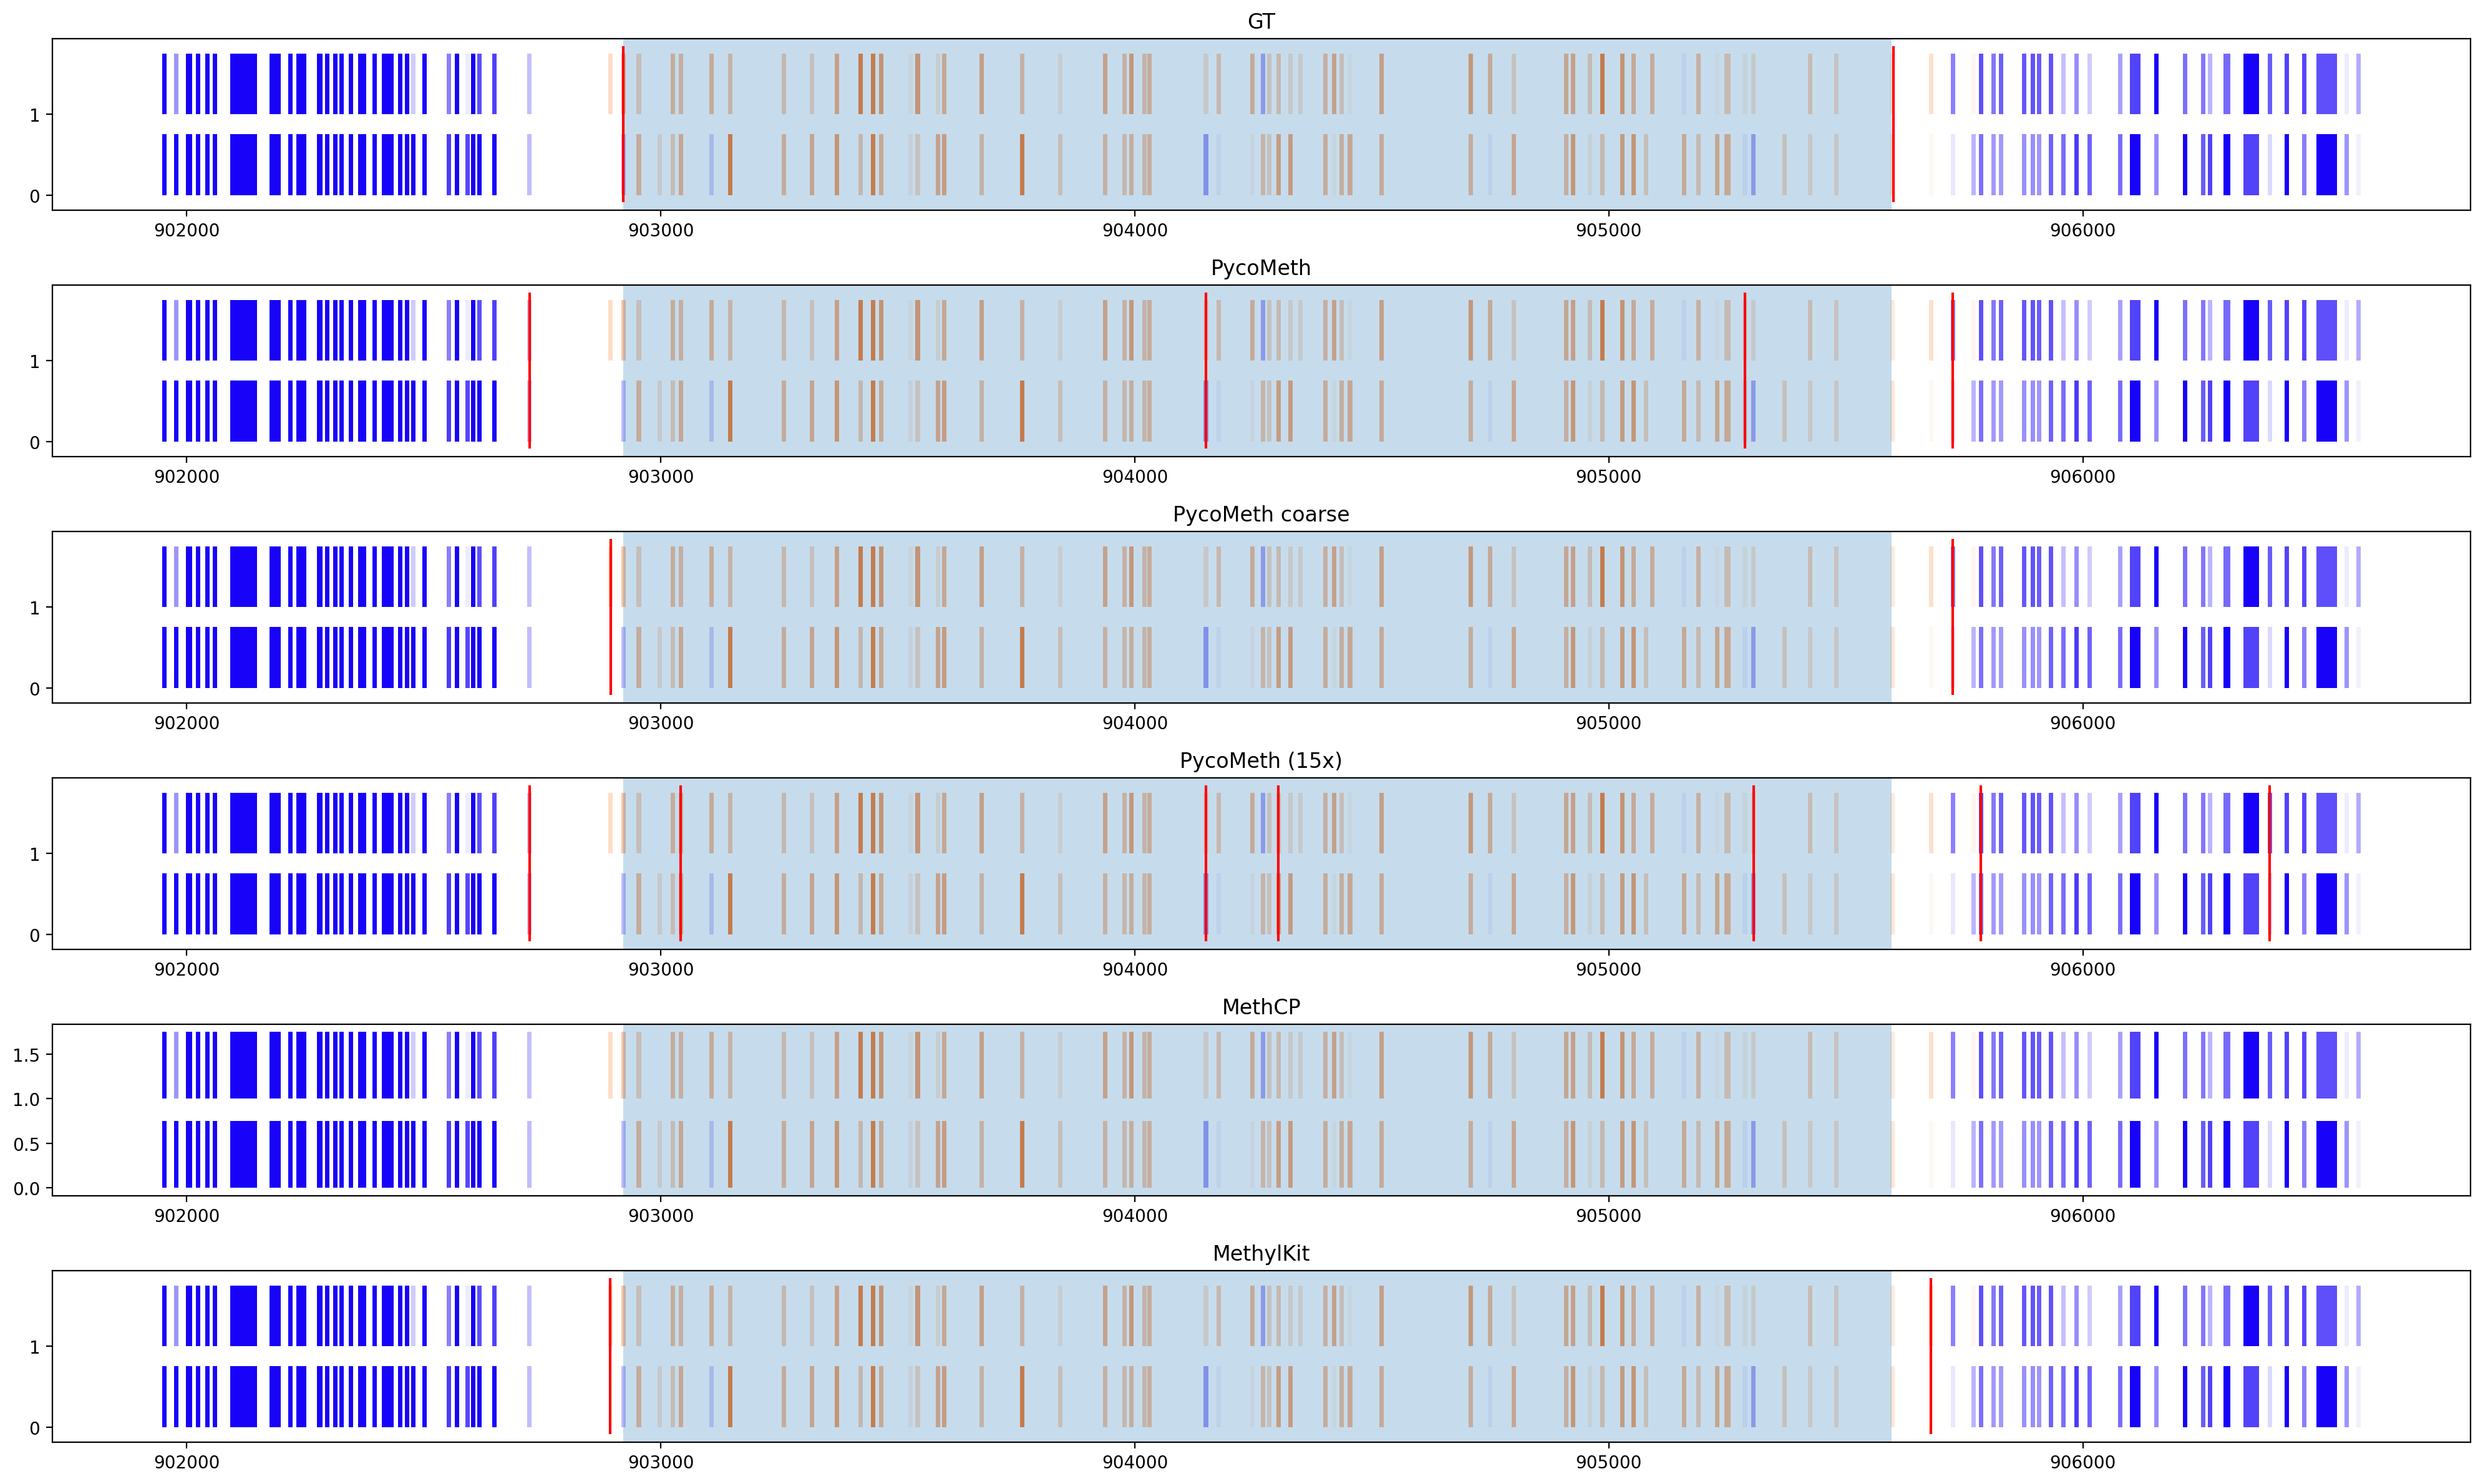

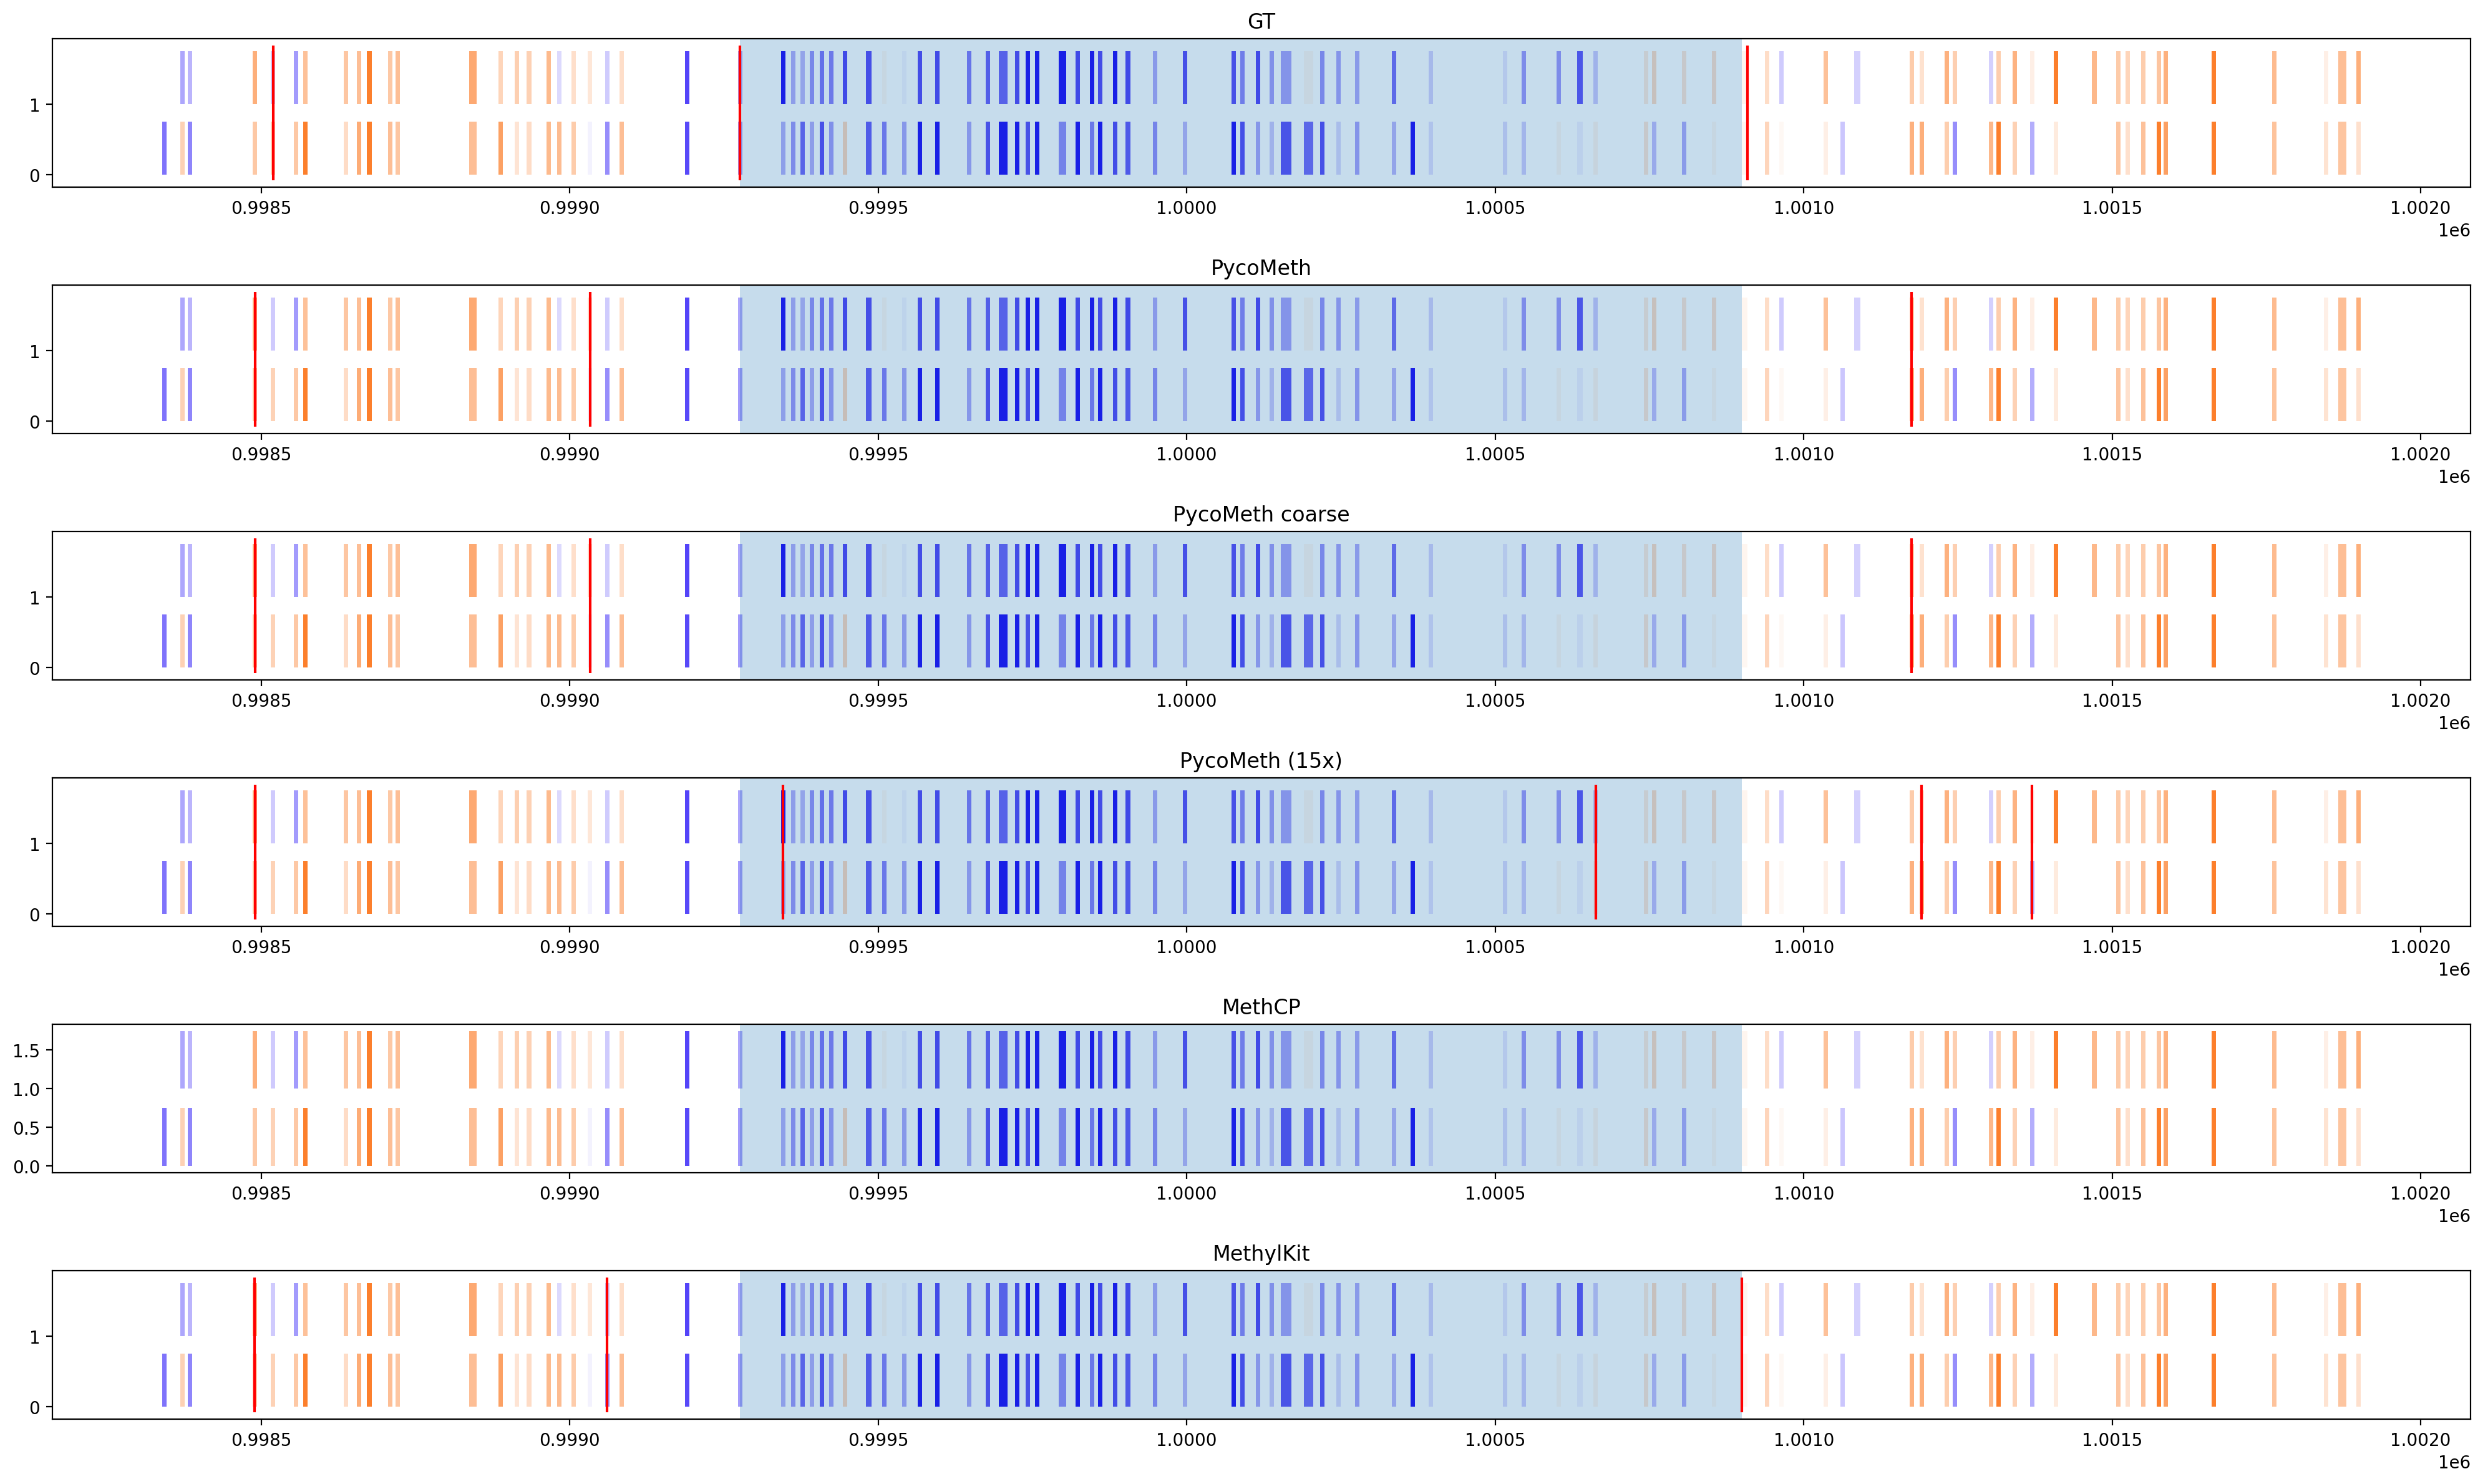

KeyboardInterrupt: 

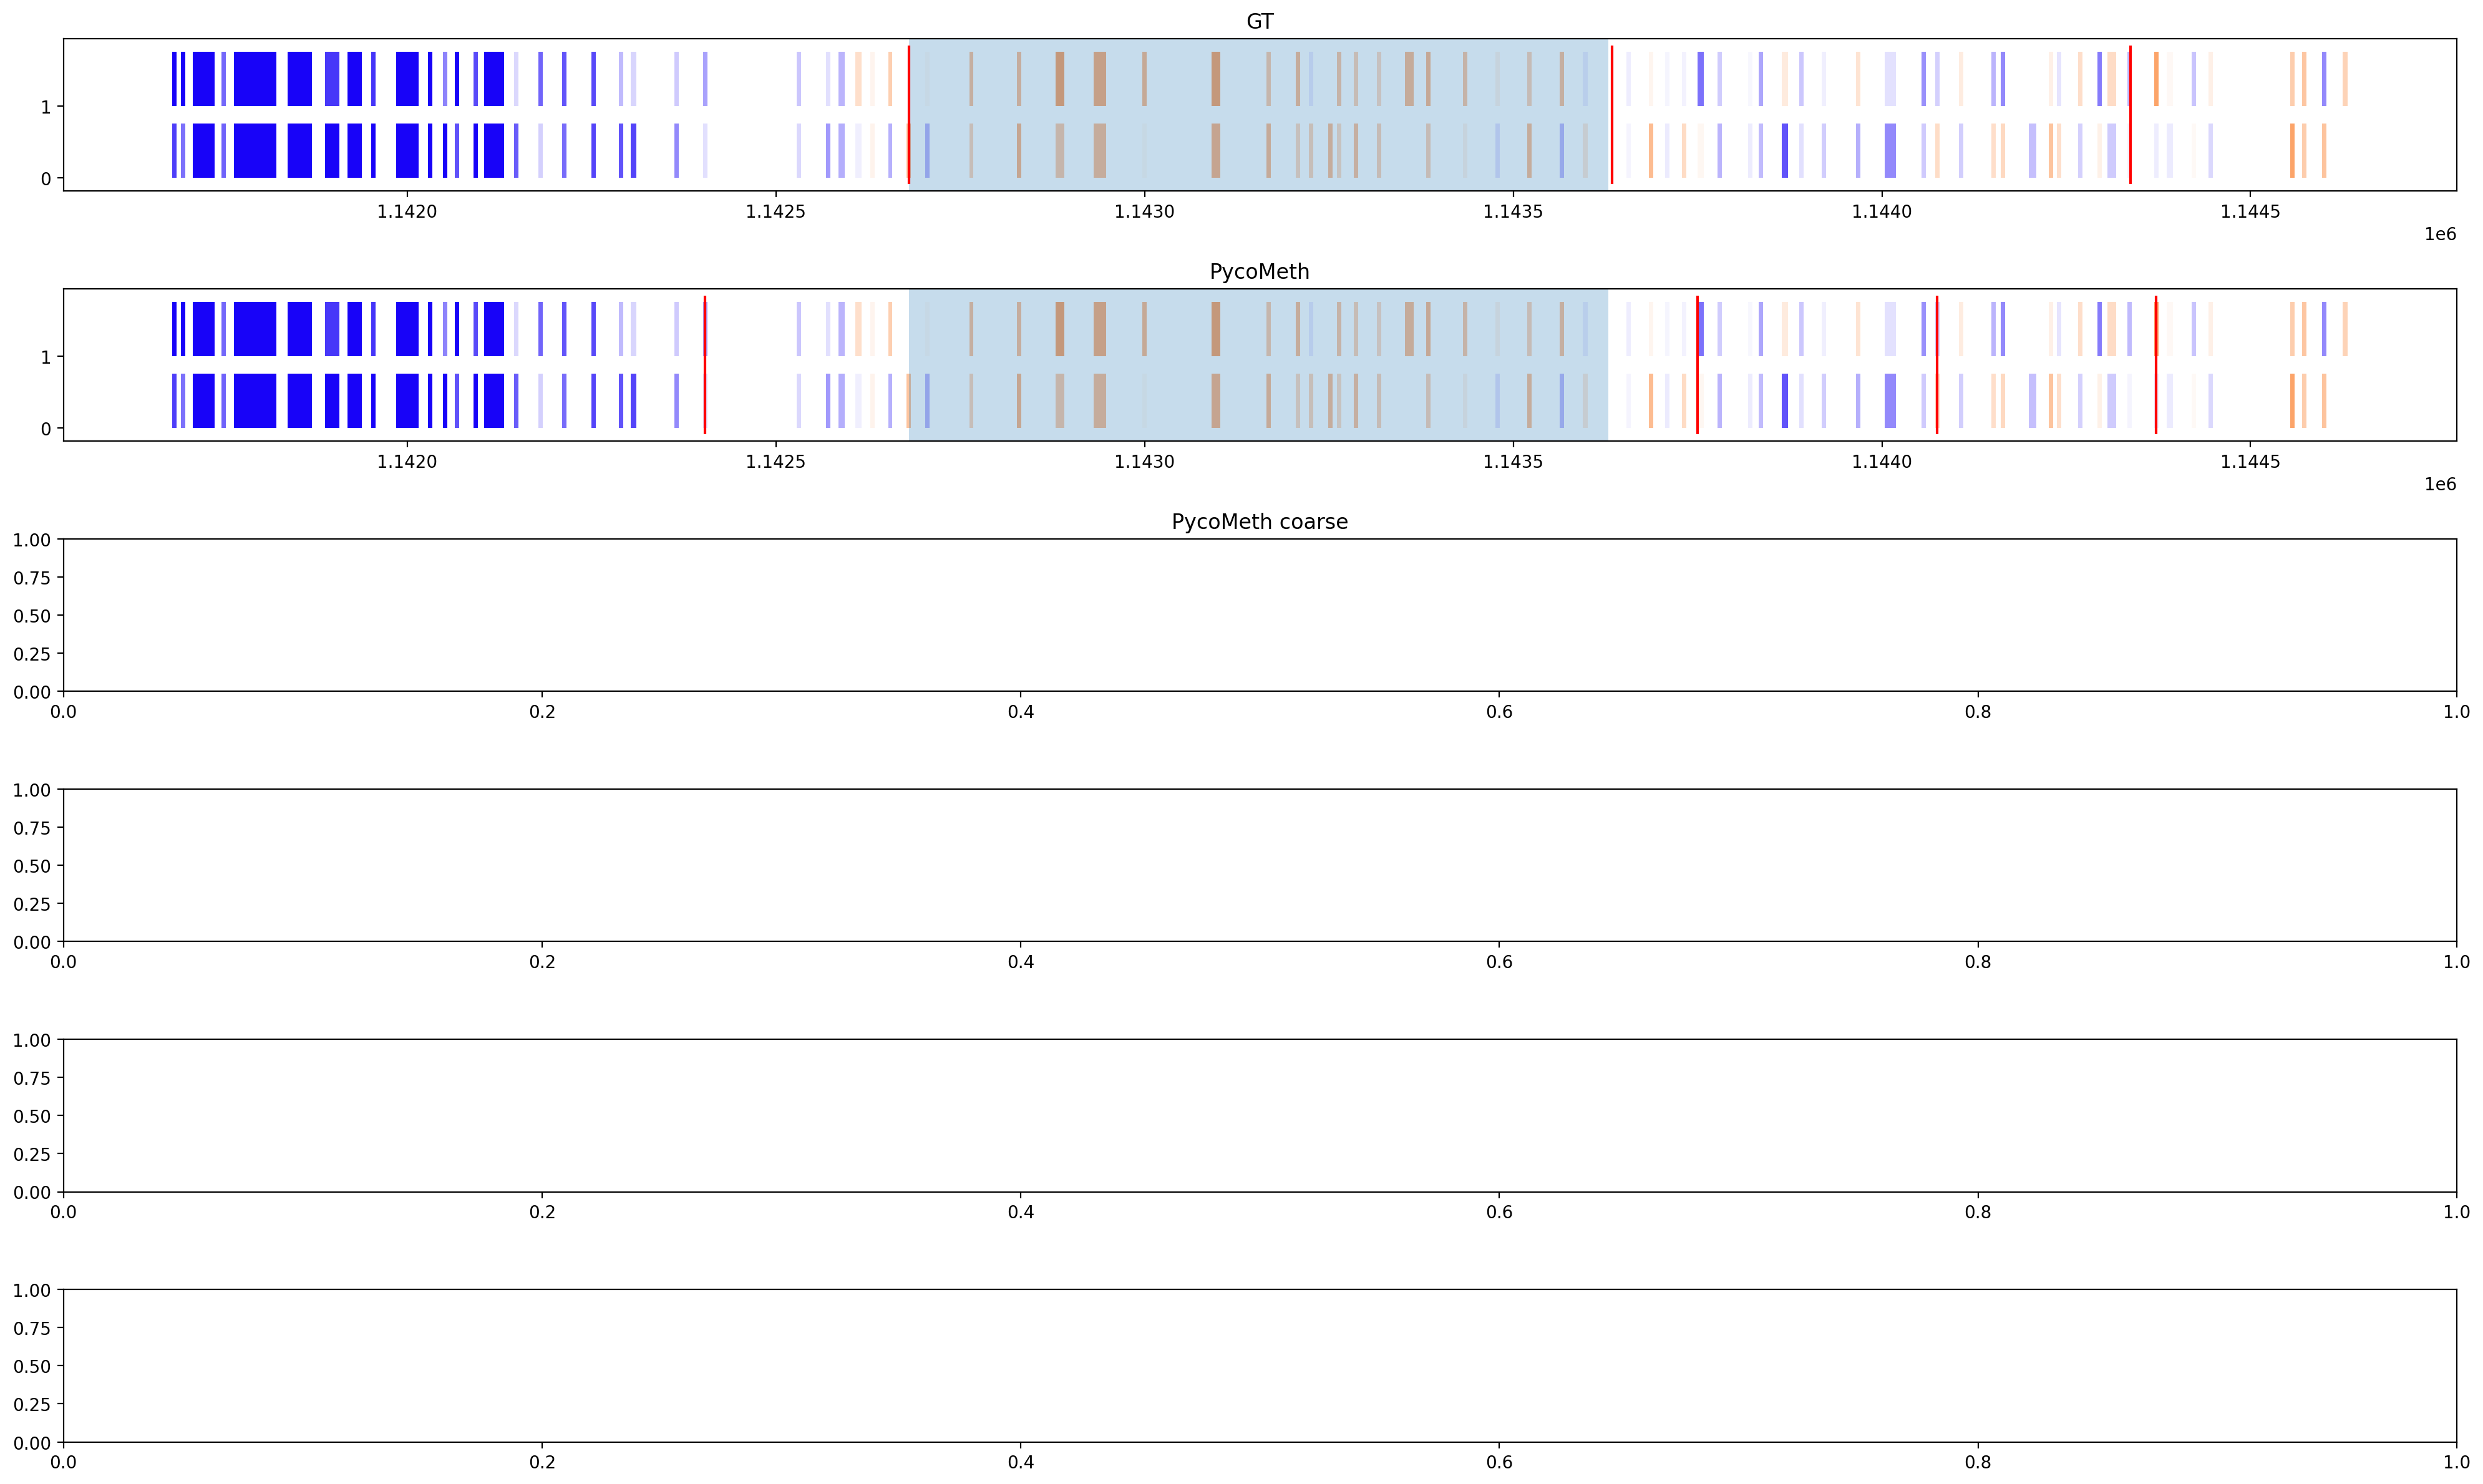

In [91]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for _, row in not_found_30.iterrows():
        plot_methylation_all_segments("1", row.start-1000, row.end+1000, highlights=[(row.start, row.end)])

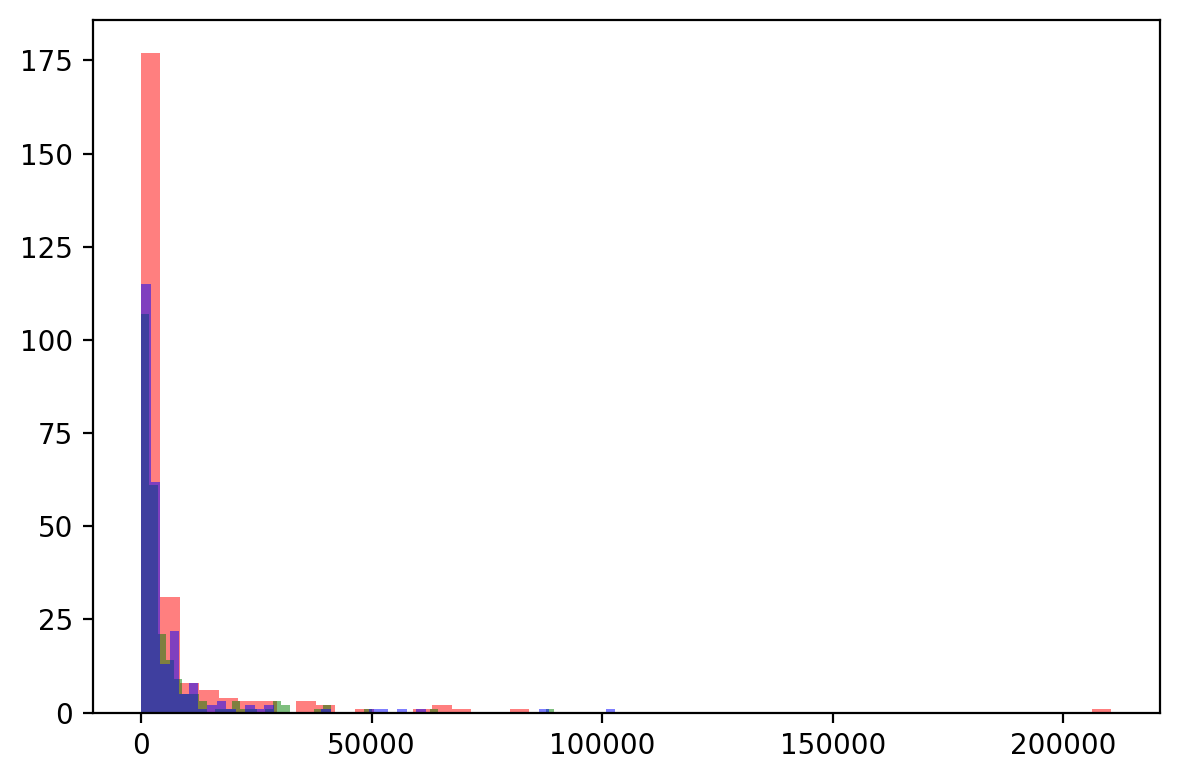

In [86]:
pa.figure()
plt.hist(gt.loc[not_found_30.index+1]["end"] - gt.loc[not_found_30.index+1]["start"], bins=50, alpha=0.5, color="r")
plt.hist(gt.loc[not_found_30.index-1]["end"] - gt.loc[not_found_30.index-1]["start"], bins=50, alpha=0.5, color="g")
plt.hist(gt.loc[not_found_30.index]["end"] - gt.loc[not_found_30.index]["start"], bins=50, alpha=0.5, color="b")
plt.show()
